In [39]:
import numpy as np

L = 10.0
N = 1024

x = np.linspace(-L, L, N, endpoint=False)
dx = x[1] - x[0]

k = (2 * np.pi / (2*L)) * np.fft.fftfreq(N, d=dx)

In [40]:
x0 = -5
sig = 0.1
k0 = 5.0


psi0 = np.exp(-(x - x0)**2 / (2 * sig**2)) * np.exp(1j * k0 * x)

# For V as a square barrier 
    -The particle is free outside, V = 0
    -Inside constant, positive V that is not 0 and not infinite
        -This allows the particle to reclect off the barrier or trasnmit


In [45]:
V = np.zeros_like(x) #Set potential equal to 0 everywhere(array)
V[(x > -1) & (x < 1)] = 2.5 #Set potential to equal 10 from -1 to 1



In [46]:
hbar = 1.0
m = 1.0
#I have these set to 1 for now to simplify the code.  Real values can be added later if necesary

T = (hbar**2 * k**2) / (2 * m)
#Kinetic energy, Fourier Space

expT = np.exp(-1j * T * (dx/2) / hbar)   # half step
expV = lambda dt: np.exp(-1j * V * dt / hbar)  # potential step

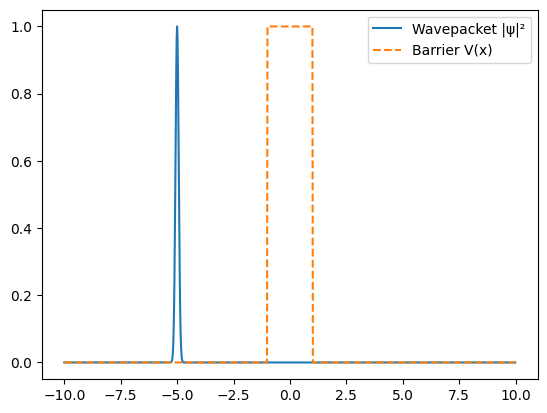

In [48]:
plt.plot(x, np.abs(psi)**2, label="Wavepacket |ψ|²")
plt.plot(x, V / np.max(V) * np.max(np.abs(psi)**2), label="Barrier V(x)", linestyle="--")  # scaled barrier for visibility
plt.legend()
plt.show()

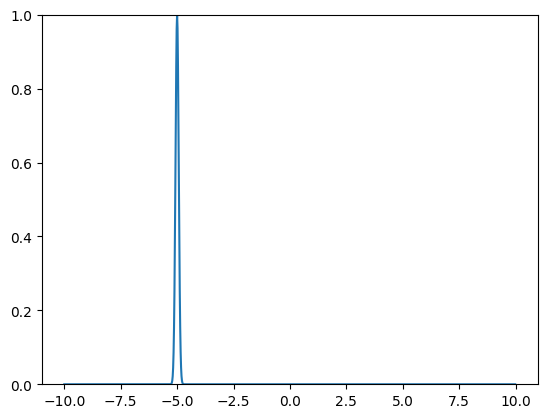

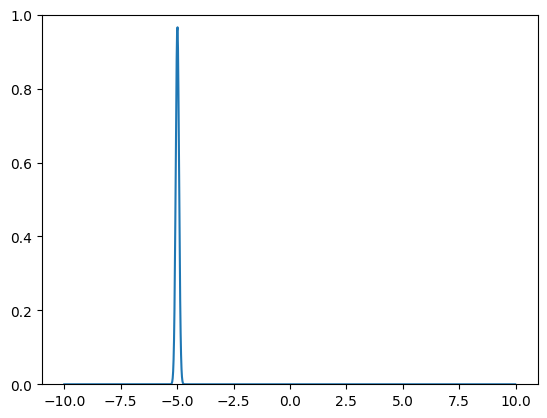

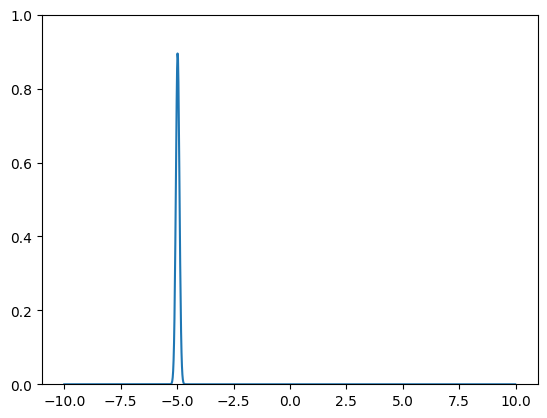

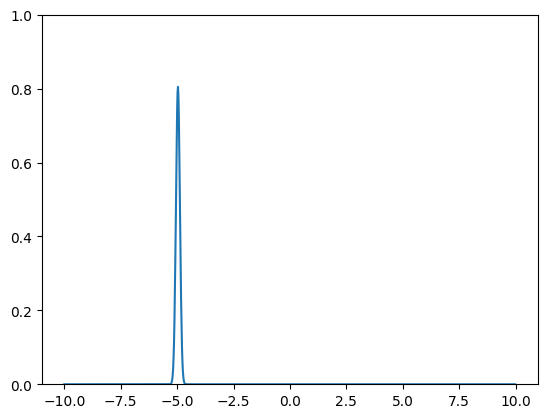

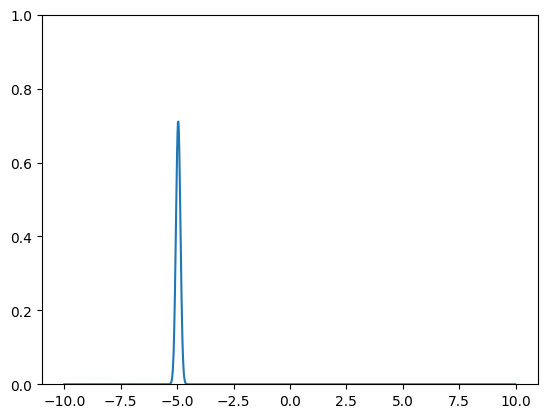

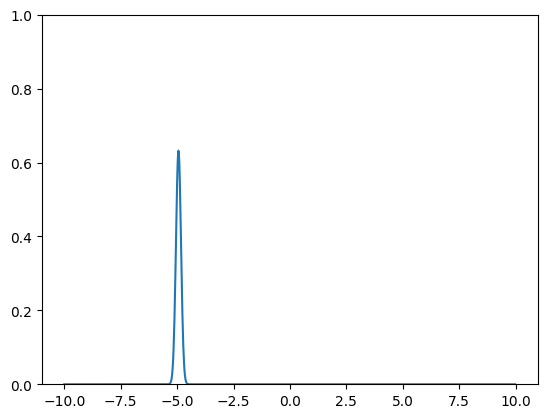

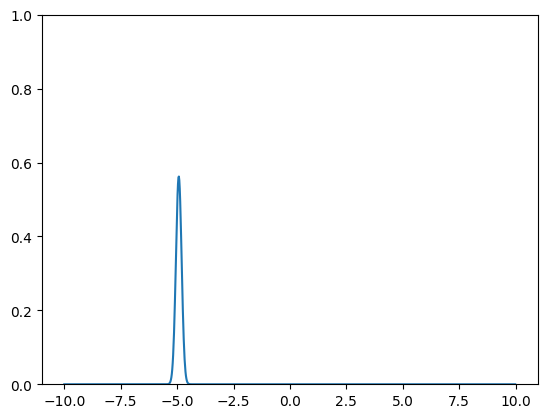

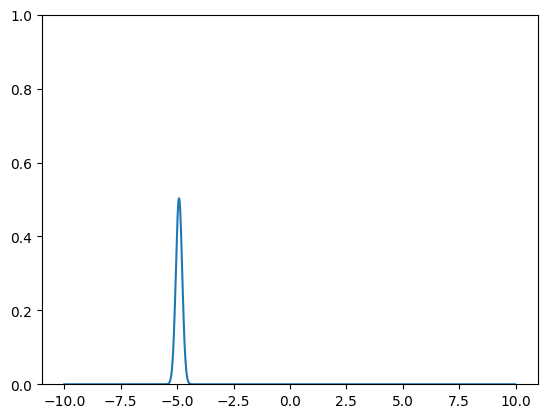

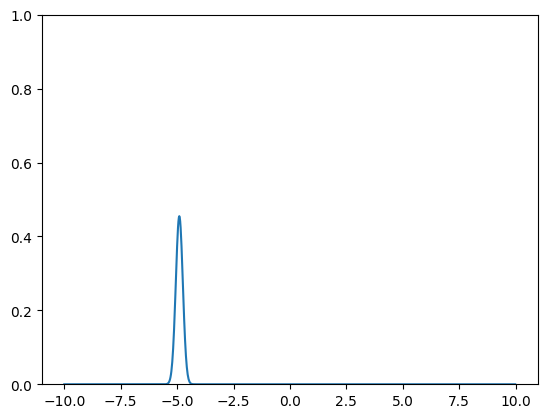

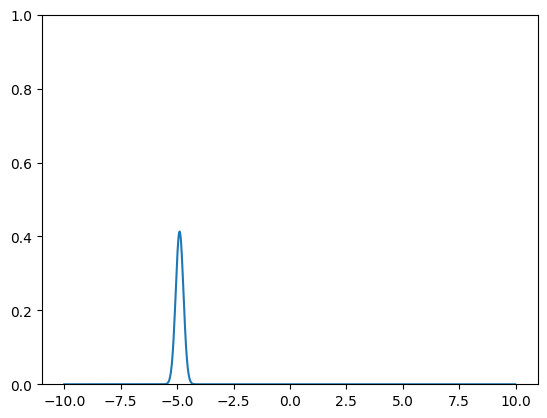

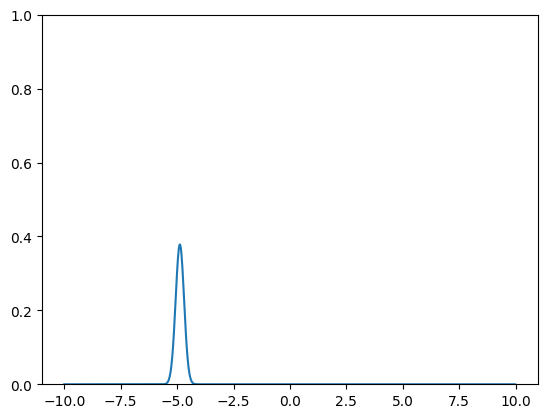

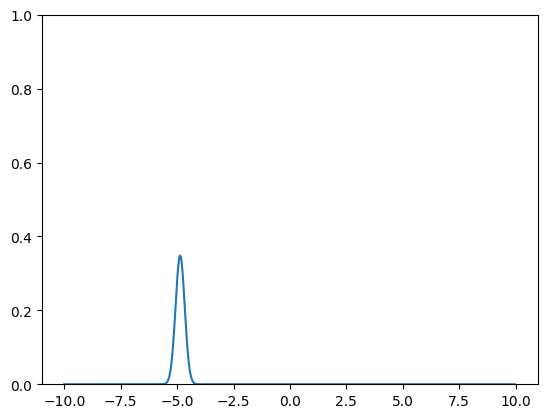

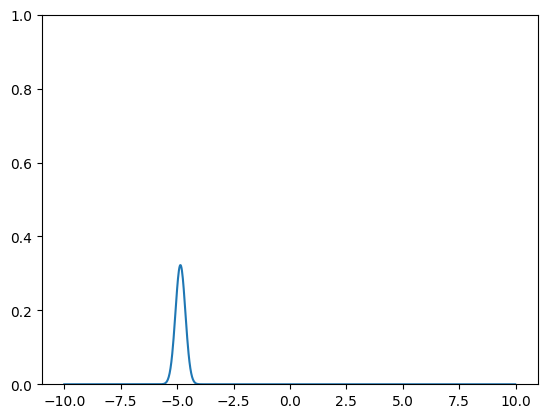

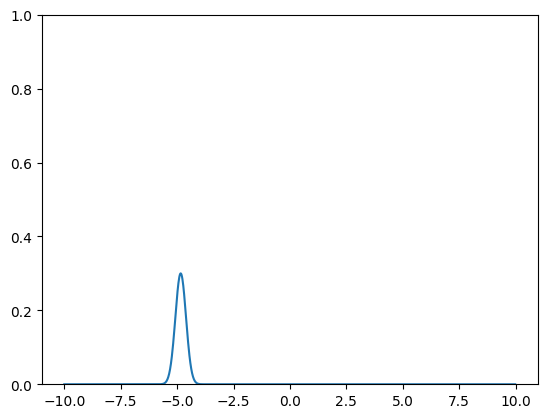

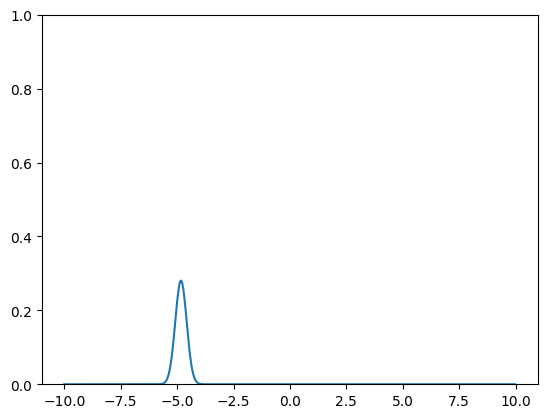

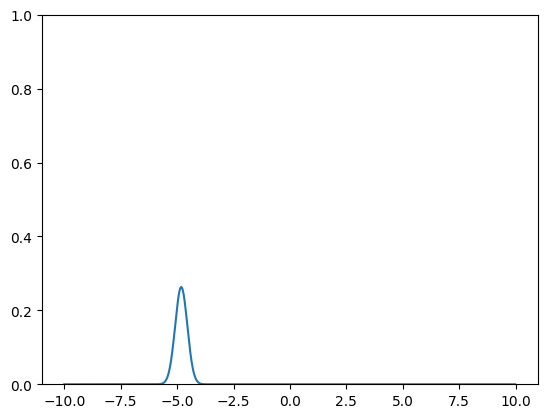

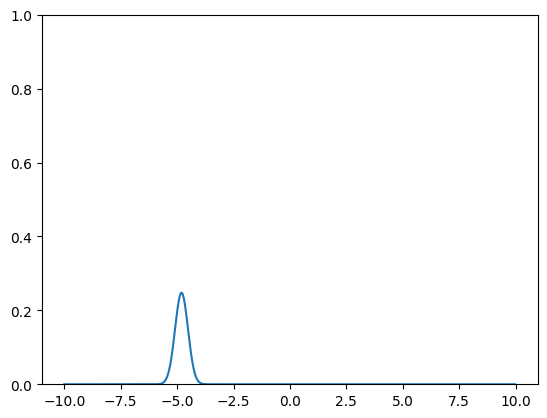

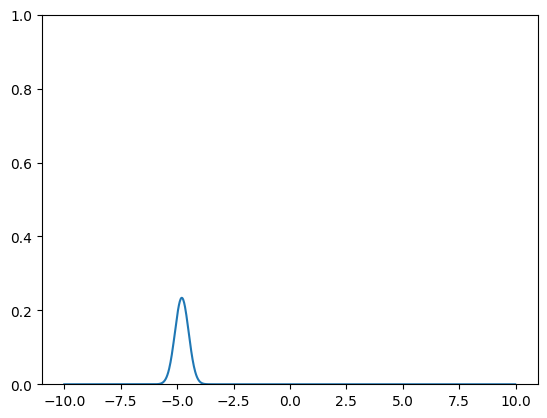

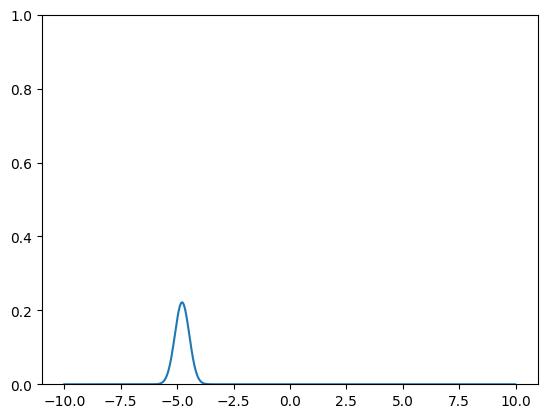

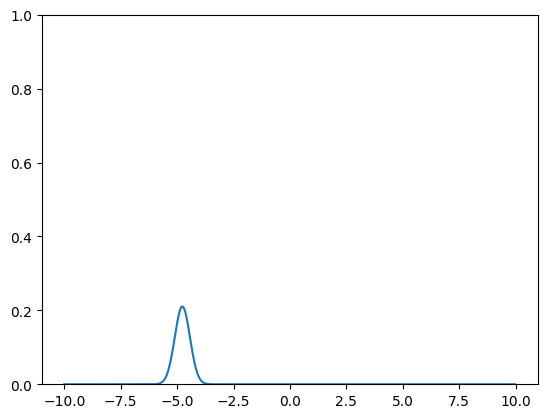

In [49]:
from matplotlib import pyplot as plt

dt = 0.1
steps = 1000

psi = psi0.copy()

for i in range(steps):
    psi_hat = np.fft.fft(psi)
    psi_hat = expT * psi_hat
    psi = np.fft.ifft(psi_hat)

    psi = expV(dt) * psi

    psi_hat = np.fft.fft(psi)
    psi_hat = expT * psi_hat
    psi = np.fft.ifft(psi_hat)

    if i % 50 == 0:
        plt.clf()
        plt.plot(x, np.abs(psi)**2)
        plt.ylim(0, 1)
        plt.pause(0.01)

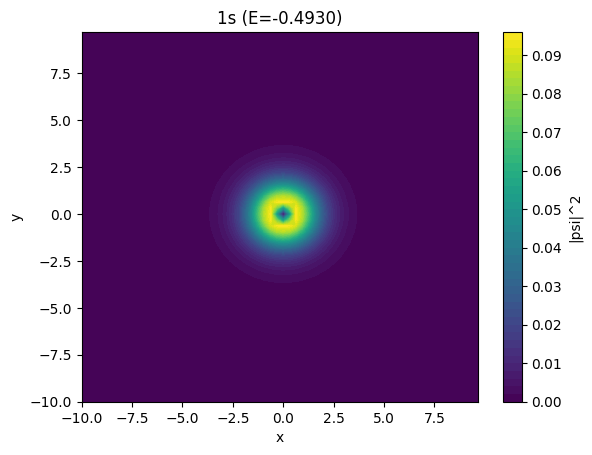

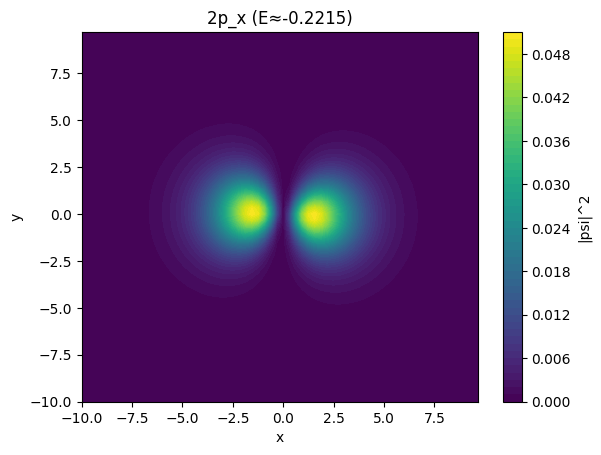

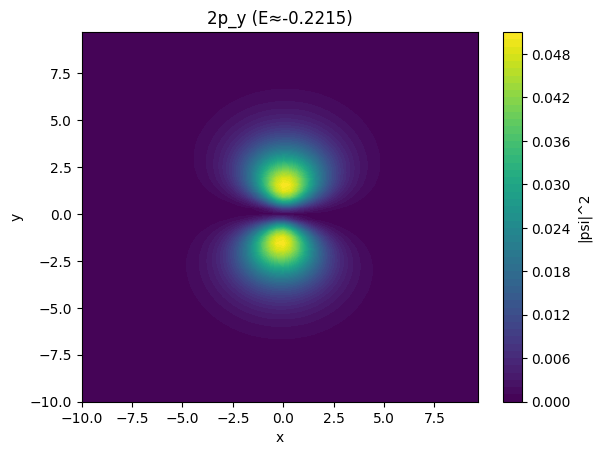

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftfreq
from scipy.sparse.linalg import eigsh, LinearOperator

# grid & potential
N = 64
L = 20.0
x = np.linspace(-L/2, L/2, N, endpoint=False)
dx = x[1] - x[0]
X, Y = np.meshgrid(x, x)
r = np.sqrt(X*X + Y*Y) + 1e-6 # adding tiny value to avoid singularity at r = 0
V = -1.0 / r

# spectral laplacian
kx = fftfreq(N, d=dx) * 2*np.pi
ky = fftfreq(N, d=dx) * 2*np.pi
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2

def lap(psi):
    return np.real(ifft2(-K2 * fft2(psi)))

def Hpsi(flat_psi):
    psi = flat_psi.reshape(N, N)
    return ( -0.5*lap(psi) + V*psi ).ravel()

H = LinearOperator((N*N, N*N), Hpsi)

evals, evecs = eigsh(H, k=4, sigma=-0.5) # finding E and psi for 1s, 2s, and the degenerate pair which gives 2px and 2py

# unpacking and normalizing orbitals
orbitals = []
for i in range(4):
    psi = evecs[:, i].reshape(N, N)
    norm = np.sqrt((np.abs(psi)**2).sum() * dx * dx)
    orbitals.append(psi / norm)

# plot 1s
psi1 = orbitals[0]
plt.figure()
plt.contourf(X, Y, np.abs(psi1)**2, levels=50)
plt.title(f"1s (E={evals[0]:.4f})")
plt.xlabel("x"); plt.ylabel("y")
plt.colorbar(label="|psi|^2")
plt.show()

# getting px and py from degenerate pair
e2, e3 = orbitals[1], orbitals[2]
px = (e2 + e3) / np.sqrt(2)
py = (e2 - e3) / np.sqrt(2)

for psi, label in [(px, "2p_x"), (py, "2p_y")]:
    plt.figure()
    plt.contourf(X, Y, np.abs(psi)**2, levels=50)
    plt.title(f"{label} (E≈{evals[1]:.4f})")
    plt.xlabel("x"); plt.ylabel("y")
    plt.colorbar(label="|psi|^2")
    plt.show()
